In [1]:
from warnings import filterwarnings 
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans

#### Read the outliers file and add a feature "prev_sold_year"

In [2]:
realtor_data_df = pd.read_csv('outliers.csv')
realtor_data_df["prev_sold_year"] = pd.to_datetime(realtor_data_df["prev_sold_date"], format='%Y-%m-%d').dt.year

In [3]:
for_sale_df = realtor_data_df

#### Create a feature that will append '0' to the zipcode feature

In [4]:
for_sale_df["zip_code_str"] = '0'+ for_sale_df["zip_code"].apply(int).apply(str)
for_sale_df.head()

,Unnamed: 0,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str
0,2,2.0,2.0,0.23,1001.0,892.0,2019-04-30,169900.0,2019,01001
1,8,2.0,3.0,0.23,1001.0,1229.0,2016-06-07,239900.0,2016,01001
2,14,2.0,2.0,0.23,1001.0,1056.0,2019-09-12,175000.0,2019,01001
3,15,2.0,2.0,0.23,1001.0,960.0,2018-12-14,195000.0,2018,01001
4,32,3.0,2.0,0.16,1002.0,1280.0,2021-08-19,275000.0,2021,01002


#### Get the unique zipcodes in the dataframe

In [5]:
zipcodes = for_sale_df["zip_code"]
len(zipcodes.unique())

197

#### Read the file with Latitude and Longitude, rename the features

In [6]:
# Because of its size this dataset is not saved in the code repo for this project.
# It can be downloaded and saved in the same path to make this Notebook run.
zip_lon_lat = pd.read_csv('../../../zip_lat_long.csv')
zip_lon_lat.rename(columns={"ZIP":"zip_code", "LAT":"latitude", "LNG":"longitude"},inplace=True)
zip_lon_lat.head()

,zip_code,latitude,longitude
0,601,18.180555,-66.749961
1,602,18.361945,-67.175597
2,603,18.455183,-67.119887
3,606,18.158345,-66.932911
4,610,18.295366,-67.125135


#### Find matching zipcodes that were found in the dataset

In [7]:
find_zipcodes_df = zip_lon_lat[zip_lon_lat["zip_code"].isin(zipcodes.unique())]
find_zipcodes_df["zip_code_str"] = "0"+find_zipcodes_df["zip_code"].apply(str)
find_zipcodes_df.head()

,zip_code,latitude,longitude,zip_code_str
142,1001,42.062368,-72.625754,01001
143,1002,42.364061,-72.458739,01002
146,1007,42.279010,-72.400468,01007
153,1020,42.172602,-72.562073,01020
154,1022,42.197741,-72.542713,01022


#### Merge the dataset with the Latitude and Longitude data

In [8]:
merge_df = for_sale_df.merge(find_zipcodes_df, how='outer', on='zip_code_str')

merge_df.rename(columns={"zip_code_x":"zip_code"},inplace=True)
merge_df.drop(columns=["zip_code_y"],inplace=True)

#### Display the records that didn't match up

In [9]:
merge_df[merge_df["latitude"].isna()]

,Unnamed: 0,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude


In [10]:
# "08218","39.1386785","-74.856442"

In [11]:
# "08239","39.1979584","-74.6577965"

In [12]:
# "08245","39.1778125","-74.8300693"

#### Drop the records that didn't match up

In [13]:
merge_df.dropna(subset=['latitude'], inplace=True)

In [14]:
merge_df.head()

,Unnamed: 0,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude
0,2,2.0,2.0,0.23,1001.0,892.0,2019-04-30,169900.0,2019,01001,42.062368,-72.625754
1,8,2.0,3.0,0.23,1001.0,1229.0,2016-06-07,239900.0,2016,01001,42.062368,-72.625754
2,14,2.0,2.0,0.23,1001.0,1056.0,2019-09-12,175000.0,2019,01001,42.062368,-72.625754
3,15,2.0,2.0,0.23,1001.0,960.0,2018-12-14,195000.0,2018,01001,42.062368,-72.625754
4,32,3.0,2.0,0.16,1002.0,1280.0,2021-08-19,275000.0,2021,01002,42.364061,-72.458739


#### Use KMeans to cluster latitude and longitude into counties

In [15]:
numberofcounties = 14
kmeans = KMeans( init="random", n_clusters=21,random_state=0)
latlong = merge_df[["latitude","longitude"]]
kmeans.fit(latlong)
y_kmeans = kmeans.predict(latlong)

#### Plot the counties

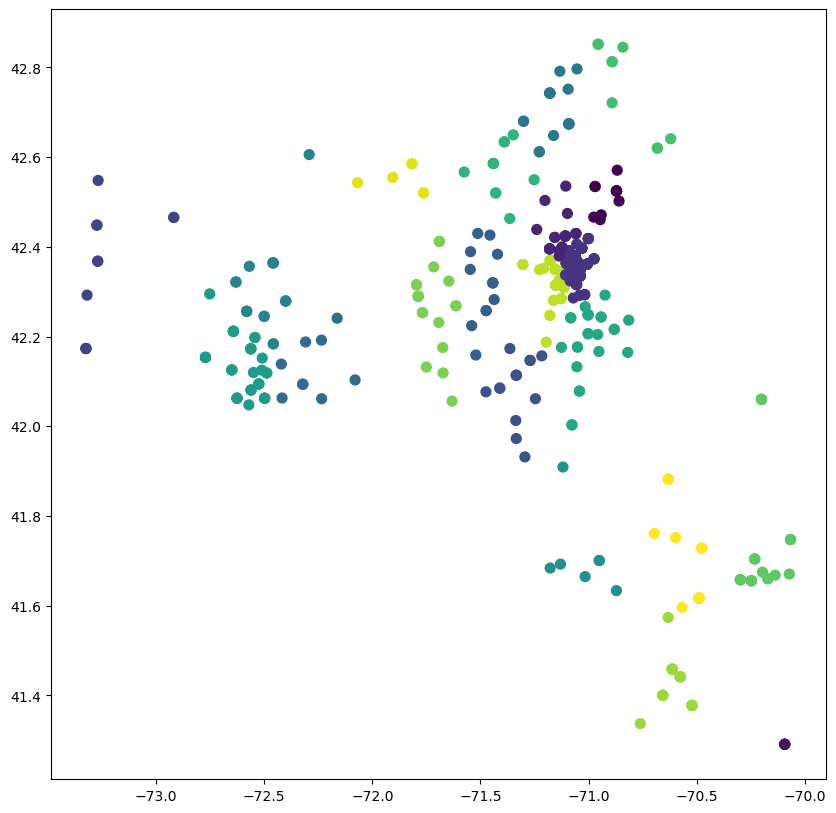

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(merge_df["longitude"], merge_df["latitude"], c=y_kmeans, s=50, cmap='viridis')

#### Add county to the dataset going forward

In [17]:
merge_df["county"] = y_kmeans

In [18]:
merge_df.head()

,Unnamed: 0,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude,county
0,2,2.0,2.0,0.23,1001.0,892.0,2019-04-30,169900.0,2019,01001,42.062368,-72.625754,11
1,8,2.0,3.0,0.23,1001.0,1229.0,2016-06-07,239900.0,2016,01001,42.062368,-72.625754,11
2,14,2.0,2.0,0.23,1001.0,1056.0,2019-09-12,175000.0,2019,01001,42.062368,-72.625754,11
3,15,2.0,2.0,0.23,1001.0,960.0,2018-12-14,195000.0,2018,01001,42.062368,-72.625754,11
4,32,3.0,2.0,0.16,1002.0,1280.0,2021-08-19,275000.0,2021,01002,42.364061,-72.458739,9


#### Save the records to a csv file

In [19]:
merge_df.to_csv("geocoded.csv")